In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import glob
import cv2
import os

from sklearn.cluster import KMeans, spectral_clustering
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

import tensorflow as tf

In [18]:
!ls data

annotations.csv frames          info.csv        video


In [19]:
info = pd.read_csv('data/info.csv', header=None)

In [20]:
# 20 annotation scores per frame for each video 
# each row is a new set of annotation scores of each video, with 20 rows per video
# scores are from 1-5
# 2 second long shot-level importance scores
annotations = pd.read_csv('data/annotations.csv', header=None)

In [21]:
# 20 videos
# 5 videos per category

# VT: Changing Vehicle Tire
# VU: Getting Vehicle Unstuck
# GA: Grooming an Animal
# MS: Making Sandwich
# PK: Parkour
# PR: Parade
# FM: Flash Mob Gathering
# BK: Bee Keeping
# BT: Attempting Bike Tricks
# DS: Dog Show

info = pd.read_csv('data/info.csv')

In [22]:
annotations.rename(columns={0: 'filename', 1: 'category', 2: 'annotations'}, inplace=True)

In [23]:
annotations.head()

,filename,category,annotations
0,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
1,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."
2,AwmHb44_ouw,VT,"3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,..."
3,AwmHb44_ouw,VT,"4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,..."
4,AwmHb44_ouw,VT,"2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,..."


In [24]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
filename       1000 non-null object
category       1000 non-null object
annotations    1000 non-null object
dtypes: object(3)
memory usage: 23.6+ KB


In [25]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [26]:
annotations['annotations'] = annotations['annotations'].apply(lambda a: a.split(','))

In [27]:
avg_annotations = []
for fname in annotations.filename.unique():
    values = annotations[annotations['filename'] == fname]['annotations'].values
    float_conversion = np.array(list(values)).astype('float64') 
    avg = np.mean(float_conversion, axis=0)
    avg_annotations.append(avg)

In [28]:
average_scores = pd.DataFrame({'filename': annotations.filename.unique(), 'average_score': avg_annotations})

In [35]:
average_scores.sort_values(by='filename')

,filename,average_score
49,-esJrBWj2d8,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
12,0tmA_C6XwfM,"[1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.1..."
18,37rzWOQsNIw,"[3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.25, 3.2..."
13,3eYKfiOEJNs,"[1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, 1.9, ..."
29,4wU_LUjG5Ic,"[1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.95, 1.9..."
25,91IHQYk1IQM,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."
1,98MoyGZKHXc,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
0,AwmHb44_ouw,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
11,Bhxk-O1Y7Ho,"[2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.95, 2.9..."
45,E11zDS9XGzg,"[1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.65, 1.6..."


In [30]:
info.columns

Index(['category', 'video_id', 'title', 'url', 'length'], dtype='object')

In [65]:
info[info['video_id'] == '-esJrBWj2d8']

,category,video_id,title,url,length
49,DS,-esJrBWj2d8,Will A Cat Eat Dog Food?,https://www.youtube.com/watch?v=-esJrBWj2d8,3:50


In [31]:
# for video in glob.glob('data/video/*.mp4'):
#     video_id = video.split('data/video/')[1].split('.mp4')[0]
#     video_capture = cv2.VideoCapture(video)
#     currentframe = 0
#     try: 
#         if not os.path.exists(f'data/frames/{video_id}'): 
#             os.makedirs(f'data/frames/{video_id}') 
#     except OSError: 
#         print ('Error: Creating directory of data')
#     while(True): 
#         ret, frame = video_capture.read() 
#         if ret: 
#             name = f'data/frames/{video_id}/' + str(currentframe) + '.jpg'
#             print ('Creating...' + name) 
#             cv2.imwrite(name, frame) 
#             currentframe += 1
#         else: 
#             break
#     video1_capture.release() 
#     cv2.destroyAllWindows() 

In [32]:
# for directory in glob.glob('data/frames/*'):
#     print(directory, len(glob.glob(f'{directory}/*')))

In [33]:
# for row in average_scores.values:
#     print(row[0], len(row[1]))

In [276]:
info.head()

,category,video_id,title,url,length
0,VT,AwmHb44_ouw,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54
1,VT,98MoyGZKHXc,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07
2,VT,J0nA4VgnoCo,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44
3,VT,gzDbaEs1Rlg,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48
4,VT,XzYM3PfTM4w,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51


In [36]:
full_df = pd.concat([info.set_index('video_id'), average_scores.set_index('filename')], axis=1, join='inner')

In [37]:
full_df = full_df.reset_index().rename(columns={'index': 'video_id'})

In [41]:
full_df.head()

,video_id,category,title,url,length,average_score
0,AwmHb44_ouw,VT,#1306 How to change tires for off road vehicle...,https://www.youtube.com/watch?v=AwmHb44_ouw,5:54,"[2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, ..."
1,98MoyGZKHXc,VT,How to use a tyre repair kit - Which? guide,https://www.youtube.com/watch?v=98MoyGZKHXc,3:07,"[1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.7..."
2,J0nA4VgnoCo,VT,#0001: FLAT TIRE,https://www.youtube.com/watch?v=J0nA4VgnoCo,9:44,"[1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.35, 1.3..."
3,gzDbaEs1Rlg,VT,ŠKODA Tips How to Repair Your Tyre,https://www.youtube.com/watch?v=gzDbaEs1Rlg,4:48,"[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, ..."
4,XzYM3PfTM4w,VT,When to Replace Your Tires GMC,https://www.youtube.com/watch?v=XzYM3PfTM4w,1:51,"[1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, 1.7, ..."


In [38]:
avg_scores_test = full_df[full_df['video_id'] == 'akI8YFjEmUw']['average_score'].values[0]

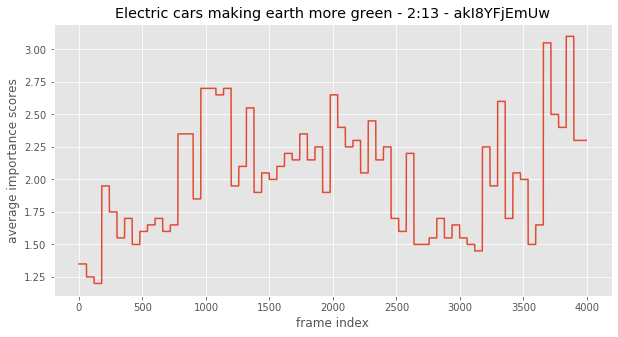

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(avg_scores_test))
ax.set_xlabel('frame index')
ax.set_ylabel('average importance scores')
ax.set_title('Electric cars making earth more green - 2:13 - akI8YFjEmUw')
ax.plot(x, avg_scores_test)

In [40]:
# 2 POTENTIAL APPROACHES

# 1. STATIC - clustering for static keyframe selection based on color histograms
# 2. DYNAMIC - create a model to take sequence of frames and predict the importance scores each frame 

In [83]:
# 3995 frames
ec_images = glob.glob('data/frames/akI8YFjEmUw/*')

In [84]:
ec_image1 = plt.imread(glob.glob('data/frames/akI8YFjEmUw/*')[500])

In [85]:
ec_images

['data/frames/akI8YFjEmUw/63.jpg',
 'data/frames/akI8YFjEmUw/823.jpg',
 'data/frames/akI8YFjEmUw/3578.jpg',
 'data/frames/akI8YFjEmUw/2666.jpg',
 'data/frames/akI8YFjEmUw/2100.jpg',
 'data/frames/akI8YFjEmUw/1409.jpg',
 'data/frames/akI8YFjEmUw/189.jpg',
 'data/frames/akI8YFjEmUw/2114.jpg',
 'data/frames/akI8YFjEmUw/2672.jpg',
 'data/frames/akI8YFjEmUw/77.jpg',
 'data/frames/akI8YFjEmUw/837.jpg',
 'data/frames/akI8YFjEmUw/2882.jpg',
 'data/frames/akI8YFjEmUw/3544.jpg',
 'data/frames/akI8YFjEmUw/1353.jpg',
 'data/frames/akI8YFjEmUw/1435.jpg',
 'data/frames/akI8YFjEmUw/3222.jpg',
 'data/frames/akI8YFjEmUw/2128.jpg',
 'data/frames/akI8YFjEmUw/3236.jpg',
 'data/frames/akI8YFjEmUw/1421.jpg',
 'data/frames/akI8YFjEmUw/1347.jpg',
 'data/frames/akI8YFjEmUw/2896.jpg',
 'data/frames/akI8YFjEmUw/3550.jpg',
 'data/frames/akI8YFjEmUw/638.jpg',
 'data/frames/akI8YFjEmUw/2869.jpg',
 'data/frames/akI8YFjEmUw/1390.jpg',
 'data/frames/akI8YFjEmUw/604.jpg',
 'data/frames/akI8YFjEmUw/2699.jpg',
 'data/fra

In [86]:
ec_image1.shape

(360, 640, 3)

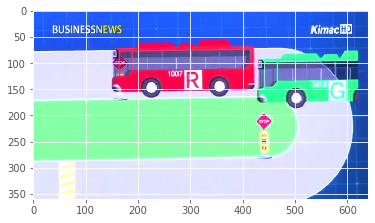

In [87]:
plt.imshow(ec_image1)

In [45]:
def get_image_features(frames_filepath):
  image_features = []
  model = VGG16(weights='imagenet', include_top=False)
  for img_path in glob.glob(frames_filepath)
  img = image.load_img(img_path, target_size=(224, 224))
  img_data = image.img_to_array(img)
  img_data = np.expand_dims(img_data, axis=0)
  img_data = preprocess_input(img_data)

  vgg16_feature = model.predict(img_data)
  image_features.append(np.array(vgg16_feature).flatten())
  return image_features

get_image_features('data/frames/akI8YFjEmUw/*')

In [58]:
np.array(image_features).shape

(3995, 25088)

In [97]:
def sort_frames(list_of_frames, video_id):
    return sorted(list_of_frames, key=lambda x: int(x.split(f'data/frames/{video_id}/')[1].split('.jpg')[0]))

In [68]:
def kmeans(image_features, n_clusters):
  silhouette = np.zeros(n_clusters)
  for k in range(2, n_clusters):
    kmeans = KMeans(n_clusters=k).fit_predict(image_features)
    silhouette[k] = silhouette_score(image_features, kmeans)
    print(f'{k} cluster complete')
  return silhouette

In [69]:
sil_scores = kmeans(image_features, 35)

2 cluster complete
3 cluster complete
4 cluster complete
5 cluster complete
6 cluster complete
7 cluster complete
8 cluster complete
9 cluster complete
10 cluster complete
11 cluster complete
12 cluster complete
13 cluster complete
14 cluster complete
15 cluster complete
16 cluster complete
17 cluster complete
18 cluster complete
19 cluster complete
20 cluster complete
21 cluster complete
22 cluster complete
23 cluster complete
24 cluster complete
25 cluster complete
26 cluster complete
27 cluster complete
28 cluster complete
29 cluster complete
30 cluster complete
31 cluster complete
32 cluster complete
33 cluster complete
34 cluster complete


Text(0, 0.5, 'silhouette score')

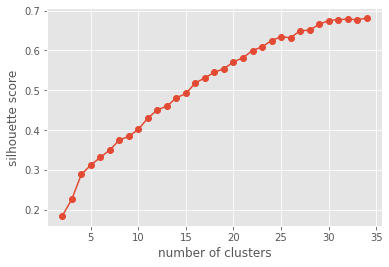

In [74]:
# Silhouette scores continually go up
fig, ax = plt.subplots()
ax.plot(range(2,35), sil_scores[2:35], 'o-')
ax.set_xlabel("number of clusters")
ax.set_ylabel("silhouette score")
#ax.set_ylim(ymin=0.0, ymax=1.0)

In [75]:
kmeans30 = KMeans(n_clusters=30, random_state=42).fit_predict(image_features)

In [89]:
np.unique(kmeans30)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)

In [88]:
ec_images_np = np.array(ec_images)

In [98]:
ec_images_np

array(['data/frames/akI8YFjEmUw/63.jpg',
       'data/frames/akI8YFjEmUw/823.jpg',
       'data/frames/akI8YFjEmUw/3578.jpg', ...,
       'data/frames/akI8YFjEmUw/2119.jpg',
       'data/frames/akI8YFjEmUw/3561.jpg',
       'data/frames/akI8YFjEmUw/1376.jpg'], dtype='<U32')

In [159]:
def random_frame_idxs_for_cluster(kmeans_labels):
  idxs = []
  for label in range(len(np.unique(kmeans_labels))):
    idxs.append(np.random.choice(np.argwhere(kmeans_labels == label).flatten(), 1)[0])
  return np.sort(np.array(idxs))

random_frame_idxs_for_cluster(kmeans30)

array([  66,   76,  172,  336,  339,  729,  921,  923, 1104, 1114, 1222,
       1316, 1351, 1380, 1411, 1490, 1810, 1897, 1987, 2482, 2524, 2535,
       2544, 2800, 2972, 3586, 3597, 3685, 3735, 3779])

In [101]:
kmeans_30_frames = sort_frames(ec_images_np[np.sort(np.array(idxs))], 'akI8YFjEmUw')

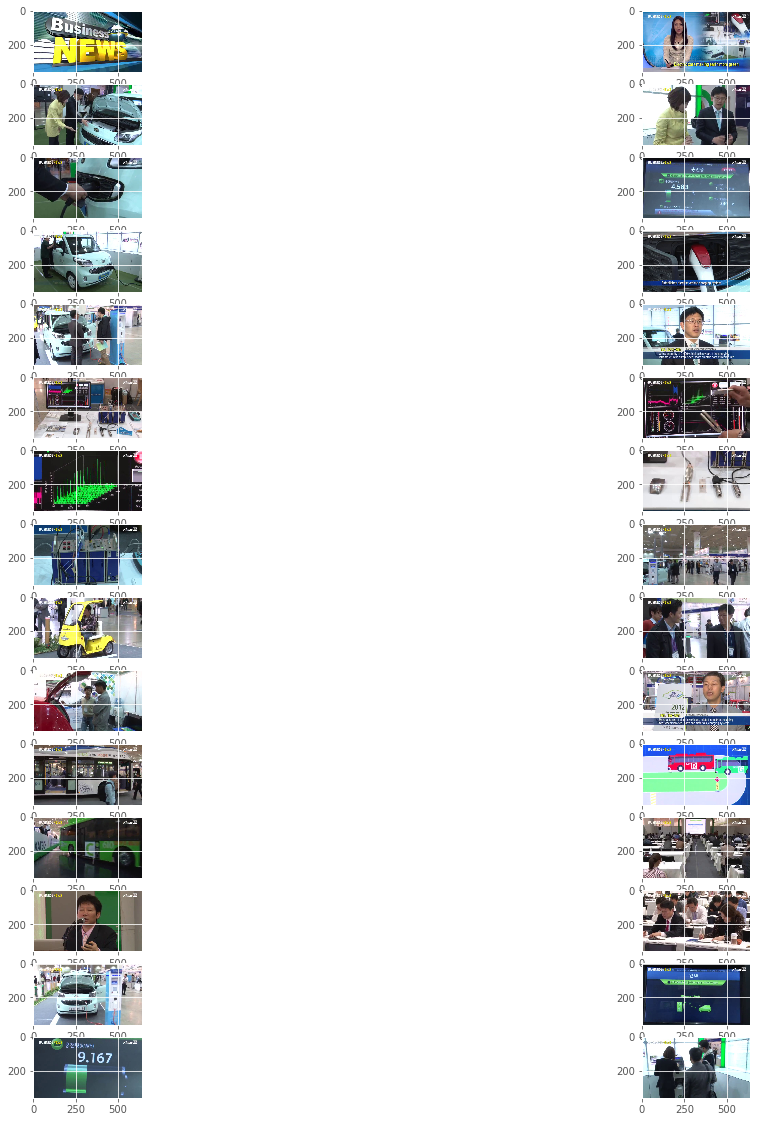

In [162]:
fig, axs = plt.subplots(15, 2, figsize=(20, 20))
for frame, ax in zip(kmeans_30_frames, axs.flatten()):
     ax.imshow(plt.imread(frame))

In [353]:
# Using Kmeans for with 400 clusters to experiment with a creating a video that is 10% of original 
kmeans = KMeans(n_clusters=400, random_state=42).fit(image_features)

In [359]:
kmeans.cluster_centers_.shape

(400, 25088)

In [384]:
kmeans.labels_

array([155, 139, 323, ..., 235, 269, 339], dtype=int32)

In [92]:
labels = kmeans.labels_
np.argwhere(labels == 315)

AttributeError: 'function' object has no attribute 'labels_'

In [397]:
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, image_features)

In [402]:
closest

array([1040, 1407,  773,  112, 3261, 2097, 2860, 3160, 3592, 2929, 3893,
       1239, 2506, 3917,  566,  142, 3482, 1851, 2075,  560, 3818, 3896,
       2303, 2795,  934, 2654, 3796, 3325, 3988, 3136, 1642,  451, 1229,
        709, 1243, 2060, 3196, 2583, 3876, 1761,  260, 2044,  272, 2995,
       2858, 2714, 3502,  643, 3860,  368, 3755,  277,  978, 3344, 3779,
       3444, 3384, 2554, 2190, 3507,  710, 3498, 3770,  367,  379, 3176,
       1256, 1905, 2680, 3405,  326, 1353, 2527, 2898,  997, 2962,  235,
       1717,  308,  564, 1907, 2495, 3681, 3691, 1460, 1313,  498,  399,
        360, 1962, 2660, 3242,  187, 2021,  863, 2163, 1334, 2123, 2741,
       2513, 1285, 3966,  306,   41, 3289, 1450, 2502, 1588, 2740, 3519,
       3426, 3672, 1551, 2735,  204, 1319, 3434, 3827, 3281, 3045, 2369,
        678, 2505, 2194,  403, 3656, 1961, 3100, 2994,  445, 2397, 2247,
       1351,  417, 2781, 3012,  229, 3797,  829,  250, 3334, 1772,  469,
       2148, 2992, 1822, 2120, 2461,  520, 1427, 33

In [425]:
ec_images_np[closest]

array(['data/frames/akI8YFjEmUw/3719.jpg',
       'data/frames/akI8YFjEmUw/3848.jpg',
       'data/frames/akI8YFjEmUw/601.jpg',
       'data/frames/akI8YFjEmUw/1555.jpg',
       'data/frames/akI8YFjEmUw/2687.jpg',
       'data/frames/akI8YFjEmUw/3472.jpg',
       'data/frames/akI8YFjEmUw/2026.jpg',
       'data/frames/akI8YFjEmUw/1987.jpg',
       'data/frames/akI8YFjEmUw/3371.jpg',
       'data/frames/akI8YFjEmUw/2422.jpg',
       'data/frames/akI8YFjEmUw/796.jpg',
       'data/frames/akI8YFjEmUw/1331.jpg',
       'data/frames/akI8YFjEmUw/126.jpg',
       'data/frames/akI8YFjEmUw/3165.jpg',
       'data/frames/akI8YFjEmUw/3620.jpg',
       'data/frames/akI8YFjEmUw/1232.jpg',
       'data/frames/akI8YFjEmUw/2137.jpg',
       'data/frames/akI8YFjEmUw/919.jpg',
       'data/frames/akI8YFjEmUw/2591.jpg',
       'data/frames/akI8YFjEmUw/1194.jpg',
       'data/frames/akI8YFjEmUw/2246.jpg',
       'data/frames/akI8YFjEmUw/2284.jpg',
       'data/frames/akI8YFjEmUw/2551.jpg',
       'data/fr

In [437]:
closest_to_center_frames = sort_frames(ec_images_np[closest], 'akI8YFjEmUw')
closest_to_center_frames

['data/frames/akI8YFjEmUw/1.jpg',
 'data/frames/akI8YFjEmUw/3.jpg',
 'data/frames/akI8YFjEmUw/6.jpg',
 'data/frames/akI8YFjEmUw/7.jpg',
 'data/frames/akI8YFjEmUw/8.jpg',
 'data/frames/akI8YFjEmUw/9.jpg',
 'data/frames/akI8YFjEmUw/11.jpg',
 'data/frames/akI8YFjEmUw/13.jpg',
 'data/frames/akI8YFjEmUw/14.jpg',
 'data/frames/akI8YFjEmUw/15.jpg',
 'data/frames/akI8YFjEmUw/16.jpg',
 'data/frames/akI8YFjEmUw/17.jpg',
 'data/frames/akI8YFjEmUw/18.jpg',
 'data/frames/akI8YFjEmUw/21.jpg',
 'data/frames/akI8YFjEmUw/23.jpg',
 'data/frames/akI8YFjEmUw/26.jpg',
 'data/frames/akI8YFjEmUw/28.jpg',
 'data/frames/akI8YFjEmUw/30.jpg',
 'data/frames/akI8YFjEmUw/33.jpg',
 'data/frames/akI8YFjEmUw/35.jpg',
 'data/frames/akI8YFjEmUw/38.jpg',
 'data/frames/akI8YFjEmUw/41.jpg',
 'data/frames/akI8YFjEmUw/46.jpg',
 'data/frames/akI8YFjEmUw/50.jpg',
 'data/frames/akI8YFjEmUw/54.jpg',
 'data/frames/akI8YFjEmUw/57.jpg',
 'data/frames/akI8YFjEmUw/61.jpg',
 'data/frames/akI8YFjEmUw/65.jpg',
 'data/frames/akI8YFjEmUw/

In [436]:
# REMEMBER TO SORT LIST OF FRAMES after glob
# sort_frames(glob.glob('data/frames/akI8YFjEmUw/*'), 'akI8YFjEmUw')

In [444]:
# 3995 
# 133 seconds
3995 / 133

30.037593984962406

In [454]:
def create_video_from_frames(frames, title, fps=30, fourcc=cv2.VideoWriter_fourcc('m','p','4','v')):
    img_array = []
    for filename in frames:
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(title, fourcc, 30, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [455]:
original_frames = sort_frames(glob.glob('data/frames/akI8YFjEmUw/*'), 'akI8YFjEmUw')
create_video_from_frames(original_frames, 'test-original.mp4')

In [456]:
create_video_from_frames(closest_to_center_frames, 'test-condensed.mp4')

In [127]:
# rgb histogram approach for clustering 

sorted_image_list = sort_frames(ec_images_np, 'akI8YFjEmUw')
# chunk_length = np.ceil(len(sorted_image_list) / 10)
# array_chunked = np.array_split(sorted_image_list, chunk_length)
# random_frames = [x[0] for x in array_chunked]

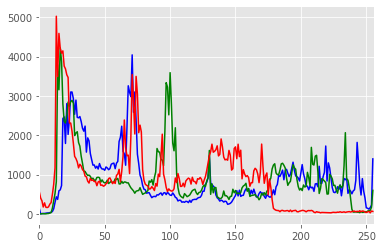

In [133]:
# Example RGB histogram 

img = cv2.imread(random_frames[100])
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [7]:
img = cv2.imread(sorted_image_list[0])
hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
(hist.shape, hist.flatten().shape[0])

NameError: name 'sorted_image_list' is not defined

In [10]:
# y = []
# for frame in random_frames:
#     img = cv2.imread(frame)
#     histr = cv2.calcHist([img],[i],None,[256],[0,256])
#     y.append(histr)

def rgb_to_hsv_histogram_features(image_list, bins):
    features = []
    for frame in image_list:
      cv_img = cv2.imread(frame)
      img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2HSV)
      histr = cv2.calcHist([cv_img], [0, 1, 2], None, [
                           bins, bins, bins], [0, 256, 0, 256, 0, 256])
      cv2.normalize(hist, hist)
      features.append(histr.flatten())
    return features

In [9]:
y = rgb_to_hsv_histogram_features(sorted_image_list)
y.shape

NameError: name 'sorted_image_list' is not defined

In [173]:
kmeans_rgb = KMeans(n_clusters=13).fit(y)

In [174]:
kmeans_rgb.labels_

array([12, 12, 12, ...,  6,  6,  6], dtype=int32)

In [175]:
kmeans_rgb.cluster_centers_

array([[ 5.30435181e+01,  4.34306564e+01,  6.00165482e+01, ...,
         1.36142761e+02,  2.15817261e+02,  9.31232422e+02],
       [ 3.50842590e+01,  9.51403809e+00,  1.06830368e+01, ...,
         1.93872107e+03,  4.49775146e+03,  1.48950029e+04],
       [ 2.24262543e+02,  1.30407715e+02,  1.44970978e+02, ...,
         6.25124512e+01,  1.07583496e+02,  4.34215820e+02],
       ...,
       [ 3.01107788e+00,  1.83899689e+00,  4.16090393e+00, ...,
         6.91154785e+01,  1.99864136e+02,  2.97555664e+02],
       [-4.27246094e-04, -7.62939453e-05, -2.28881836e-05, ...,
         1.25238037e+01,  2.62115479e+01,  2.43295898e+01],
       [ 2.91174951e+03,  8.53042847e+02,  7.77896362e+02, ...,
         8.53527539e+03,  8.55629492e+03,  1.34783320e+04]], dtype=float32)

In [176]:
random_frame_idxs_for_cluster(kmeans_rgb.labels_)

array([  39, 1040, 1279, 1495, 2158, 2256, 2730, 3168, 3234, 3493, 3627,
       3841, 3946])

In [177]:
rfi = random_frame_idxs_for_cluster(kmeans_rgb.labels_)

In [180]:
# random_frames = np.array(random_frames)
sorted_image_list = np.array(sorted_image_list)

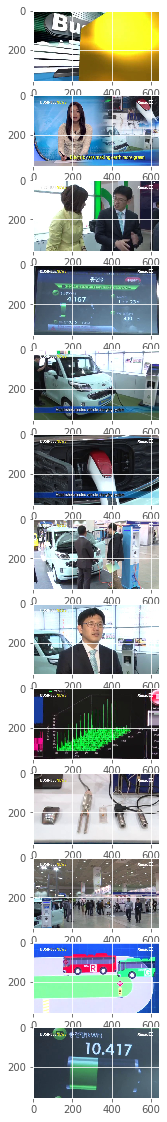

In [183]:
rgb_13_frames = sort_frames(sorted_image_list[rfi], 'akI8YFjEmUw')

fig, axs = plt.subplots(13, 1, figsize=(20, 20))
for frame, ax in zip(rgb_13_frames, axs.flatten()):
     ax.imshow(plt.imread(frame))